In [1]:
# default_exp update

# Calculating Carbon Intensity

<br>

### Imports

In [35]:
#exports
import pandas as pd
import numpy as np
import json

import dask
import dask.dataframe as dd

import matplotlib.pyplot as plt
import seaborn as sns

import os
from ipypb import track
import FEAutils as hlp

In [3]:
from IPython.display import JSON

In [4]:
# Loading
df_emissions = pd.read_csv('../data/eutl/verified_emissions.csv').set_index('account_id')

# Cleaning
df_emissions = (df_emissions
                .replace('Excluded', np.nan)
                .replace('Not Reported', np.nan)
                .astype(float))

# Checking
assert (df_emissions<0).sum().sum() == 0, 'Negative emissions are present'

df_emissions.head()

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
account_id,,,,,,,,,,,,,,,,,,,,,
100000,87923.0,106745.0,117404.0,126296.0,105795.0,105034.0,101784.0,21384.0,5671.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100001,134139.0,138143.0,170415.0,143182.0,149405.0,142121.0,119263.0,102751.0,101881.0,99012.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100002,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#exports
def get_B1610_columns(data_dir):
    B1610_files = [f for f in os.listdir(data_dir) if '.csv' in f]

    columns = []

    for B1610_file in track(B1610_files, label='columns'):
        df_B1610_week = pd.read_csv(f'{data_dir}/{B1610_file}')
        columns += list(df_B1610_week.columns)

    columns = ['datetime'] + sorted(list(set(columns)-set(['datetime'])))

    return columns

In [6]:
B1610_dir = '../data/elexon'
B1610_columns = get_B1610_columns(B1610_dir)

B1610_columns[:5]

        columns [█████████████████████████████████████████████] 288/288 [00:14<00:00, 0.05s/it]

['datetime', 'ABRBO-1', 'ABRTW-1', 'ABTH7', 'ABTH7G']

In [7]:
#exports
@dask.delayed
def read_B1610_file(filename, columns):
    df_B1610_week = pd.read_csv(filename)
    cols_to_add = list(set(columns) - set(df_B1610_week.columns))
    df_B1610_week[cols_to_add] = np.NaN
    df_B1610_week = df_B1610_week[columns]
    
    return df_B1610_week

def load_B1610_dask_stream_df(data_dir, dt_col='datetime', columns=None):
    # Identifying columns
    if columns is None:
        columns = get_B1610_columns(data_dir)
    
    # Loading data
    B1610_files = [f for f in os.listdir(data_dir) if '.csv' in f]
    df_B1610 = dd.from_delayed([read_B1610_file(f'{data_dir}/{B1610_file}', columns) for B1610_file in B1610_files])

    # Formatting date index
    if dt_col is not None:
        df_B1610[dt_col] = df_B1610[dt_col].map(lambda dt: pd.to_datetime(dt, format='%Y-%m-%d %H:%M:%S', errors='coerce', utc=True))
        df_B1610 = df_B1610.set_index(dt_col)
    
    return df_B1610

In [8]:
%%time

ddf_B1610 = load_B1610_dask_stream_df(B1610_dir, columns=B1610_columns)
df_B1610 = ddf_B1610.compute()

df_B1610.head()

Wall time: 1min 20s


,ABRBO-1,ABRTW-1,ABTH7,ABTH7G,ABTH8,ABTH8G,ABTH9,ABTH9G,ACHRW-1,AKGLW-2,...,WILCT-1,WLNYO-2,WLNYO-3,WLNYO-4,WLNYW-1,WTMSO-1,WYLF-1,WYLF-2,WYLF-3,WYLF-4
datetime,,,,,,,,,,,,,,,,,,,,,
2015-10-04 23:00:00+00:00,NaN,NaN,421.692,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,132.90,NaN,NaN,95.602,9.858,227.380,212.410,NaN,NaN
2015-10-04 23:30:00+00:00,NaN,NaN,425.096,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,143.02,NaN,NaN,107.324,14.890,227.470,212.530,NaN,NaN
2015-10-05 00:00:00+00:00,NaN,NaN,423.292,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,158.98,NaN,NaN,118.342,23.074,227.666,212.720,NaN,NaN
2015-10-05 00:30:00+00:00,NaN,NaN,431.148,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,163.18,NaN,NaN,140.900,36.890,227.826,212.844,NaN,NaN
2015-10-05 01:00:00+00:00,NaN,NaN,418.772,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,160.86,NaN,NaN,148.838,47.772,228.054,213.086,NaN,NaN


In [9]:
with open('../data/mappings/ngc_bmu_id_to_eutl_account_id.json', 'r') as fp:
    ngc_bmu_to_eutl_account_id = json.load(fp)
    
JSON([ngc_bmu_to_eutl_account_id])

<IPython.core.display.JSON object>

In [10]:
with open('../data/mappings/ngc_bmu_id_to_fuel.json', 'r') as fp:
    ngc_bmu_id_to_fuel = json.load(fp)
    
JSON([ngc_bmu_id_to_fuel])

<IPython.core.display.JSON object>

In [11]:
s_ngc_bmu_id_to_fuel = pd.Series(ngc_bmu_id_to_fuel)
potential_emitting_ngc_bmu_ids = s_ngc_bmu_id_to_fuel[~s_ngc_bmu_id_to_fuel.isin(['wind', 'npshyd', 'nuclear', 'ps', 'hydro'])].index

print(f'There are {len(potential_emitting_ngc_bmu_ids)} NGC BMU ids that are potentially carbon emitting')

There are 252 NGC BMU ids that are potentially carbon emitting


In [67]:
print(f'There are {len(ngc_bmu_to_eutl_account_id)} NGC BMU ids that have been mapped to an eutl account')

There are 202 NGC BMU ids that have been mapped to an eutl account


In [12]:
ngc_bmu_ids_in_B1610_without_fuel_mapping = sorted(list(set(df_B1610.columns) - set(ngc_bmu_id_to_fuel.keys())))

assert len(ngc_bmu_ids_in_B1610_without_fuel_mapping) == 0, f'The following NGC BMU ids are associated with power plants in the B1610 dataframe but do not have an associated fuel type:\n{", ".join(ngc_bmu_ids_in_B1610_without_fuel_mapping)}'

In [13]:
account_ids_not_in_emissions_df = sorted(list(set(ngc_bmu_to_eutl_account_id.values()) - set(df_emissions.index)))

assert len(account_ids_not_in_emissions_df) == 0, f'The following account ids are associated with power plants but do not have an entry in the emissions dataframe:\n{", ".join(account_ids_not_in_emissions_df)}'

In [14]:
ngc_bmu_ids_not_in_B1610_df = sorted(list(set(ngc_bmu_to_eutl_account_id.keys()) - set(potential_emitting_ngc_bmu_ids)))

assert len(ngc_bmu_ids_not_in_B1610_df) == 0, f'The following account ids are associated with carbon emitting power plants but do not have an entry in the emissions dataframe:\n{", ".join(account_ids_not_in_emissions_df)}'

In [15]:
relevant_ngc_bmu_ids = sorted(list(set(potential_emitting_ngc_bmu_ids) & set(B1610_columns) & set(ngc_bmu_to_eutl_account_id.keys())))
s_ngc_bmu_to_eutl_account_id = pd.Series(ngc_bmu_to_eutl_account_id).loc[relevant_ngc_bmu_ids]
unique_accounts_ids = sorted(list(s_ngc_bmu_to_eutl_account_id.unique()))

df_power = pd.DataFrame()

for accounts_id in track(unique_accounts_ids):
    ngc_bmu_ids_associated_with_account = list(s_ngc_bmu_to_eutl_account_id[s_ngc_bmu_to_eutl_account_id==accounts_id].index)
    df_power[accounts_id] = df_B1610[ngc_bmu_ids_associated_with_account].sum(axis=1)
    
df_power.head()

 [████████████████████████████████████████████████████████████] 59/59 [00:01<00:00, 0.02s/it]

,96786,96827,96842,96864,96869,96873,96880,96899,96903,96906,...,97781,97910,98249,98251,98253,98257,98286,112433,116565,117846
datetime,,,,,,,,,,,,,,,,,,,,,
2015-10-04 23:00:00+00:00,0.0,261.304,1712.068,0.0,0.0,0.0,444.8,0.0,321.3,0.0,...,142.12,0.0,0.0,0.0,431.558,0.0,0.0,0.0,0.0,0.0
2015-10-04 23:30:00+00:00,0.0,260.428,1580.588,0.0,0.0,0.0,307.7,0.0,324.6,0.0,...,142.10,0.0,0.0,0.0,431.794,0.0,0.0,0.0,0.0,0.0
2015-10-05 00:00:00+00:00,0.0,258.540,1692.684,0.0,0.0,0.0,235.4,0.0,336.8,0.0,...,142.02,0.0,0.0,0.0,461.178,0.0,0.0,0.0,0.0,0.0
2015-10-05 00:30:00+00:00,0.0,259.374,1817.112,0.0,0.0,0.0,231.5,0.0,348.9,0.0,...,142.12,0.0,0.0,0.0,463.120,0.0,0.0,0.0,0.0,0.0
2015-10-05 01:00:00+00:00,0.0,259.592,1800.868,0.0,0.0,0.0,231.7,0.0,321.1,0.0,...,142.12,0.0,0.0,0.0,441.080,0.0,0.0,0.0,0.0,0.0


In [16]:
df_relevant_emissions = df_emissions.T[df_power.columns]
df_relevant_emissions.index = df_relevant_emissions.index.astype(int)

df_relevant_emissions.head(3)

account_id,96786,96827,96842,96864,96869,96873,96880,96899,96903,96906,...,97781,97910,98249,98251,98253,98257,98286,112433,116565,117846
2005,1104318.0,2685512.0,20771624.0,1756762.0,35449.0,1750824.0,2030737.0,1420032.0,3553376.0,1561667.0,...,707518.0,2549691.0,1343281.0,8492925.0,8413055.0,1548481.0,915500.0,NaN,NaN,NaN
2006,1142501.0,2693932.0,22764847.0,1738464.0,57291.0,1798929.0,2143213.0,1960340.0,3109891.0,1298763.0,...,745367.0,3448929.0,1742317.0,8404878.0,8865656.0,1329097.0,829208.0,NaN,NaN,NaN
2007,1404009.0,2695748.0,22160413.0,1802979.0,32686.0,1943600.0,2146205.0,2261133.0,3610228.0,2070388.0,...,723444.0,3236835.0,1889513.0,5635923.0,8287912.0,1705103.0,869831.0,NaN,NaN,NaN


In [17]:
df_annual_power = df_power['2016':'2020'].resample('Y').sum()/2 # /2 to convert MW to MWh
df_annual_power.index = df_annual_power.index.year

df_annual_power

,96786,96827,96842,96864,96869,96873,96880,96899,96903,96906,...,97781,97910,98249,98251,98253,98257,98286,112433,116565,117846
datetime,,,,,,,,,,,,,,,,,,,,,
2016,2361844.510,0.000,1.993557e+07,4650643.65,623.36,4149322.700,7721634.800,4457540.899,7449541.45,4978154.970,...,919893.340,1490503.596,1802497.265,1844939.505,798832.338,2393667.565,0.00,2696485.5,0.577,0.000
2017,1391963.650,0.000,2.030758e+07,3560728.95,1170.44,2627556.800,6761155.150,5774100.898,7035427.85,3934558.935,...,880434.660,2468365.630,2295307.750,1900711.768,0.000,2381409.958,0.00,4672856.6,0.040,0.000
2018,917007.656,1274784.605,1.829174e+07,2778260.50,502.30,1981281.400,7288425.483,3249380.445,6582401.50,3935109.330,...,1030475.113,4794831.142,2533506.125,1167262.796,0.000,1457296.637,0.00,4524152.1,0.005,0.000
2019,892863.650,2444746.457,1.449977e+07,4474174.55,1857.76,3228100.902,7627097.975,3005538.436,7053247.80,2024271.270,...,969367.815,4207197.310,2032307.860,1154560.551,0.000,1698224.211,178026.56,4075254.8,347561.653,42834.081
2020,61773.955,2625222.674,1.614134e+07,3446762.85,470.14,1907092.600,7237835.541,2540818.182,6791530.15,1430692.065,...,992358.312,3438142.039,2018613.490,982491.471,0.000,2001115.211,228405.41,2372011.2,1431336.141,49028.584


In [18]:
df_annual_carbon_intensity = pd.DataFrame()
s_carbon_intensity = pd.Series(index=df_relevant_emissions.columns, dtype='float64')

for account_id in df_relevant_emissions.columns:
    s_emissions = df_relevant_emissions.loc[2016:2020, account_id]
    s_power = df_annual_power.loc[2016:2020, account_id]
        
    df_annual_carbon_intensity[account_id] = 1000*s_emissions/s_power
    
    weights = s_power.loc[df_annual_carbon_intensity[account_id].dropna().index]
    
    if len(weights) > 0:
        s_carbon_intensity[account_id] = np.average(df_annual_carbon_intensity[account_id].dropna(), weights=weights)

df_annual_carbon_intensity = df_annual_carbon_intensity.replace(np.inf, np.nan)

df_annual_carbon_intensity.head()

C:\Users\Ayrto\anaconda3\envs\PowerEmissions\lib\site-packages\numpy\lib\function_base.py:412: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


,96786,96827,96842,96864,96869,96873,96880,96899,96903,96906,...,97781,97910,98249,98251,98253,98257,98286,112433,116565,117846
2016,381.206297,NaN,309.556085,384.775127,1065.195072,381.701332,444.893483,366.482560,400.314707,388.460587,...,665.539116,403.649479,394.461625,1064.548726,928.978416,387.639877,NaN,370.669525,NaN,NaN
2017,382.640021,NaN,306.054191,389.256812,1017.566044,387.899131,460.113683,364.759992,399.555515,397.979806,...,773.056799,384.990776,395.282506,1024.842921,NaN,399.591006,NaN,365.217071,NaN,NaN
2018,381.150580,34.536815,226.265042,413.032903,1057.137169,395.363829,462.587840,402.831562,415.234470,405.648704,...,681.281858,398.651369,404.992113,1147.432270,NaN,424.990345,NaN,382.466584,NaN,NaN
2019,379.857552,5.533498,50.052577,381.937044,1014.662820,397.477662,440.758990,374.385164,393.098198,395.574947,...,660.080715,375.195619,395.169952,1032.954919,NaN,400.763925,2737.445469,365.366357,438.109322,306.274810
2020,405.073627,3.969949,94.602010,387.427583,1342.153401,400.879852,447.241027,378.369065,394.478408,399.276696,...,620.069377,376.356470,402.435634,1097.374412,NaN,404.430487,2027.338144,370.949345,379.347649,547.456153


<AxesSubplot:ylabel='Count'>

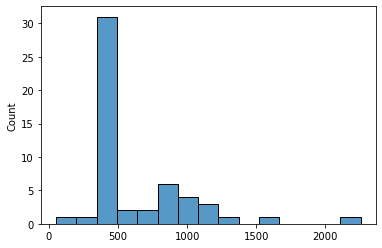

In [19]:
sns.histplot(s_carbon_intensity, bins=15)

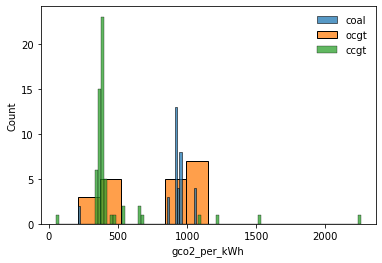

In [20]:
df_ngc_bmu_emissions = pd.DataFrame({
    'fuel': s_ngc_bmu_id_to_fuel.loc[s_ngc_bmu_to_eutl_account_id.index],
    'gco2_per_kWh': s_ngc_bmu_to_eutl_account_id.map(s_carbon_intensity)
})

sns.histplot(df_ngc_bmu_emissions.query('fuel=="coal"')['gco2_per_kWh'], color='C0', label='coal')
sns.histplot(df_ngc_bmu_emissions.query('fuel=="ocgt"')['gco2_per_kWh'], color='C1', zorder=-1, label='ocgt')
sns.histplot(df_ngc_bmu_emissions.query('fuel=="ccgt"')['gco2_per_kWh'], color='C2', label='ccgt')

plt.legend(frameon=False)

In [21]:
(df_ngc_bmu_emissions.query('fuel=="ccgt"&gco2_per_kWh>1000')
 .append(df_ngc_bmu_emissions.query('fuel=="coal"&gco2_per_kWh<500'))
 .append(df_ngc_bmu_emissions.query('fuel=="ccgt"&gco2_per_kWh<200'))
 .append(df_ngc_bmu_emissions.query('fuel=="ocgt"&gco2_per_kWh<300')))

,fuel,gco2_per_kWh
BRGG-1,ccgt,1529.903446
BRYP-1,ccgt,1089.698372
FELL-1,ccgt,2253.477026
PETEM1,ccgt,1228.267320
DRAXX-5,coal,210.571595
DRAXX-6,coal,210.571595
FAWN-1,ccgt,53.257617
DRAXX-10G,ocgt,210.571595
DRAXX-12G,ocgt,210.571595
DRAXX-9G,ocgt,210.571595


In [22]:
# BRGG-1 now has a recip turbine as well - https://www.centrica.com/news/centrica-completes-two-50mw-fast-response-plants-brigg-and-peterborough
# BRYP-1 default mode became open-cycle in 2012 - https://en.wikipedia.org/wiki/Barry_Power_Station
# FELL-1 is likely including other emissions from sellafield
# PETEM1 added 5 recips in 2017 - https://www.centrica.com/media-centre/news/2017/centrica-starts-construction-on-new-gas-plant-at-peterborough-power-station/
# DRAX is completely thrown by the conversion to biomass (which seems to count as 0 emissions for the ETS)

In [58]:
hist_counts, bin_edges = np.histogram(df_plot.query('fuel=="coal"')['gco2_per_kWh'], range=range_, bins=bins)

max(hist_counts)

25

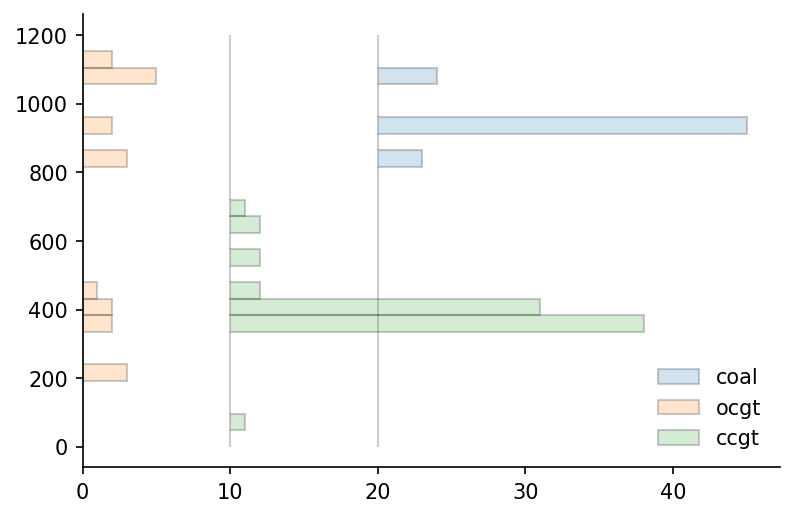

In [60]:
alpha = 0.2
range_ = (0, 1200)# specify the range and have all using the same number of bins (so spacing is the same)
bins = 25

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.hist(df_plot.query('fuel=="coal"')['gco2_per_kWh'], bottom=20, edgecolor='k', bins=bins, range=range_, alpha=alpha, orientation='horizontal', label='coal')
ax.hist(df_plot.query('fuel=="ocgt"')['gco2_per_kWh'], bottom=0, edgecolor='k', bins=bins, range=range_, alpha=alpha, orientation='horizontal', label='ocgt')
ax.hist(df_plot.query('fuel=="ccgt"')['gco2_per_kWh'], bottom=10, edgecolor='k', bins=bins, range=range_, alpha=alpha, orientation='horizontal', label='ccgt')

ax.legend(frameon=False)
hlp.hide_spines(ax)

<AxesSubplot:xlabel='fuel', ylabel='gco2_per_kWh'>

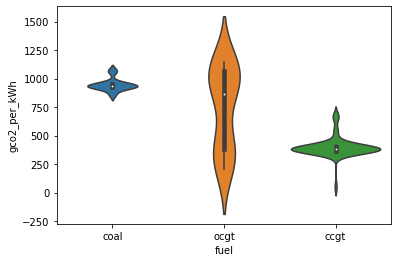

In [23]:
misleading_plants = ['DRAXX-5', 'DRAXX-6', 'BRGG-1', 'BRYP-1', 'FELL-1', 'PETEM1']
df_plot = df_ngc_bmu_emissions.query('fuel!="oil"&fuel!="biomass"').dropna().drop(misleading_plants)

sns.violinplot(data=df_plot, x='fuel', y='gco2_per_kWh', scale='count')

<AxesSubplot:xlabel='gco2_per_kWh', ylabel='Count'>

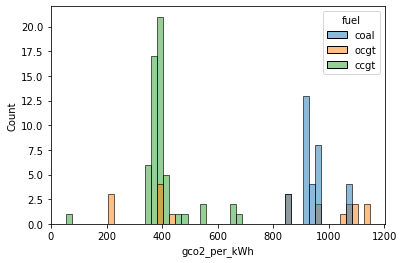

In [24]:
sns.histplot(data=df_plot, hue='fuel', x='gco2_per_kWh', bins=50)

In [61]:
df_ngc_bmu_emissions.query('gco2_per_kWh>1000').sort_values('gco2_per_kWh', ascending=False)

,fuel,gco2_per_kWh
FELL-1,ccgt,2253.477026
BRGG-1,ccgt,1529.903446
PETEM1,ccgt,1228.267320
COWE1,ocgt,1149.573513
COWE2,ocgt,1149.573513
TAYL2G,ocgt,1103.622979
TAYL3G,ocgt,1103.622979
BRYP-1,ccgt,1089.698372
FIDL-1,coal,1066.967401
FIDL-2,coal,1066.967401
